# Importar drivers

## Os drivers estão todos localizados na pasta Instruments

In [2]:
from instruments.M8195A_driver import * # Driver do AWG
from instruments.ATS9872_driver import * # Placa Alazar

## A biblioteca de medida está localizada na pasta measurements.

In [3]:
from measurements.DataChannelManager import * # Contém classe que gerencia os dados para serem carregados no AWG
from measurements.PulseSequence import * # Classe que estratura e sequencia os pulsos

# Diferentes tipos de pulsos que podem ser usados

from measurements.waveforms.SquarePulse import *
from measurements.waveforms.ZeroPulse import *
from measurements.waveforms.GaussianPulse import *
from measurements.waveforms.DragPulse import *

# Biblioteca dos Outros Instrumentos

In [4]:
# drivers de controle dos instrumentos
from instruments.ATS9872_driver import * # alazar placa de aquisição
from instruments.DG645_driver import * # delay generator 
from instruments.M8195A_driver import * # awg
from instruments.E8257D_driver import * #RF source
from instruments.E5063A_driver import * #VNA
from instruments.Agilent11713C_driver import * # attenuator
from instruments.SIM928_driver import * # Voltage source
from instruments.SIM970_driver import * # Voltage meter

## Outras bibliotecas para ajudar na medida

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from time import sleep
import struct
from IPython.display import clear_output
from datetime import datetime


# Configura os outros Instrumentos

In [9]:
att_address='TCPIP0::169.254.101.101::inst0::INSTR'
RFsourceMeasurement_address='TCPIP0::169.254.101.103::inst0::INSTR'
RFsourceExcitation_address='TCPIP0::169.254.101.104::inst0::INSTR'
Voltsource_address='GPIB0::2::INSTR'
Voltsource_channel=8
Voltmeter_address='GPIB0::2::INSTR'
Voltmeter_channel=5
vna = E5063A_driver("TCPIP0::169.254.101.105::inst0::INSTR")
# alazar, placa de aquisição
inst_att = Agilent11713C_driver(att_address)
inst_RFsourceMeasurement = E8257D_driver(RFsourceMeasurement_address)
inst_RFsourceExcitation = E8257D_driver(RFsourceExcitation_address)
inst_voltsource =  SIM928_driver(Voltsource_address,Voltsource_channel,step_time=0.1,step_voltage=0.001)
inst_voltmeter = SIM970_driver(Voltmeter_address,Voltmeter_channel)

In [6]:
# inst_att = Agilent11713C_driver(att_address)

In [7]:
# inst_att.get_attenuation()

## Configura as fontes

In [10]:
# temos que configurar a fonte no modo de pulsos com trigger externo
# a polaridade escolhida da fonte depende do canal utilizado do awg.
# todo canal do awg é duplicado. Ele vai ter um canal normal e outro que idêntico ao normal só que invertido.
# A fonte de medida recebe o invertido enquando a placa alazar recebe o normal. Eu faço isso para
# manter o nível do trigger igual em ambos.
inst_RFsourceMeasurement.set_pulse_trigger_external()
inst_RFsourceMeasurement.setPulsePolarityInverted()
inst_RFsourceMeasurement.start_mod()


# A fonte de excitação recebe o canal 3 - marker 1 -  normal
inst_RFsourceExcitation.set_pulse_trigger_external()
inst_RFsourceExcitation.setPulsePolarityNormal()
inst_RFsourceExcitation.start_mod()

# Configuramos amplitude do sinal da fonte de medida. Ela tem que ser o suficiente para alimentar os mixers que heterodinagem.
# calculamos que seu valor deve ser 18 dBm.
inst_RFsourceMeasurement.set_amplitude(18)

# A fonte de excitação não é necessariamente usada no processo de medida da cavidade (a menos que se queira ver os deslocamento dispersivo de frequência)
# no caso sua amplitude é por volta de 11 dBm
#inst_RFsourceExcitation.set_amplitude(11)

In [11]:
# parar as fontes
inst_RFsourceMeasurement.stop_rf()
inst_RFsourceExcitation.stop_rf()

## Configurar AWG

In [12]:
inst_awg = M8195A_driver('169.254.101.100')

inst_awg.setSampleRate(64e9)

# tem que conectar também o awg a nossa referência de rubídio 10 MHz
inst_awg.setRefInClockExternal()  
inst_awg.setRefInClockFrequency(10e6)

# configura o awg para usar dois canais (um de excitação, outro de medida) e usar dois markers
# o canal 1 gerará o sinal de excitação I e o sinal de medida
# o canal 2 gerará o sinal de excitação Q
# o canal 3 será o marker 1 - para ligar a fonte 2, fonte de excitação
# o canal 4 será o marker 2 - para ligar a fonte 1, de medida, e para trigar a placa de aquisição alazar
inst_awg.setDualWithMarker()

# dividir a memória em 2
inst_awg.setMemoryDivision(2)
# usar a memória externa para o canal 2
inst_awg.setChannelMemoryToExtended(2)


# markers should have 1 V amplitude and offset 0.5
inst_awg.setVoltage(3,1) 
inst_awg.setVoltage(4,1)

inst_awg.setVoltageOffset(3,0.5) 
inst_awg.setVoltageOffset(4,0.5)

inst_awg.enableChanneloutput(1)
inst_awg.enableChanneloutput(2)
inst_awg.enableChanneloutput(3)
inst_awg.enableChanneloutput(4)

In [13]:
inst_awg.getError()

In [14]:
inst_awg.stop()

## Configurar Alazar

In [15]:
inst_alazar = ATS9872_driver()

alazar_params = {}

RFMeasurementLength = 5e-6 # Escolher a duração do pulso de medida

#
# Values that work for recordsPerBuffer and BuffersPerAcquisition
#                           25                    20
#                           100                   20
#                           500                   100
alazar_params['recordsPerBuffer'] = 500  # número de capturas por buffer.
alazar_params['buffersPerAcquisition'] = 100 # número de buffers por aquisição.
alazar_params['amplitudeReferenceAlazar'] = -8 # Intensidade do sinal de referência.
alazar_params['inputLoad'] = 50# impedância dos cabos. 
alazar_params['triggerLevel_volts'] = 0.7  # Level do trigger para ativar captura.
alazar_params['triggerRange_volts'] = 1            # Tamanho máximo do sinal do trigger.
alazar_params['waveformHeadCut'] = 1500 # quanto pontos iniciais por captura vão ser ignorados.
alazar_params['period'] = 4# for 20mhz???  - 14 # o período em pontos do sinal capturado ( 70 MHz -> 14 pontos).
alazar_params['buffer_timeout_ms'] = 5000 # tempo de espera para chegar um buffer; se ultrapassar, ocorre timeout.
alazar_params['decimationValue'] = 1 # valor de divisão do sampling rate.
alazar_params['TTL'] = True # Configuração do sinal de trigger. É o que funcionaou quando estava trigando pelo AWG. Quando é pelo delay generator, não usa isso.
alazar_params['save'] = False # Caso queira salvar todos os pontos adquiridos na aquisição em formato binário.


alazar_params['DefaultAlazarSamplingRate'] = 1e9
samplingRate =  alazar_params['DefaultAlazarSamplingRate']/alazar_params['decimationValue']

# O número pontos por aquisição depende do sampling rate. Tem que ser múltiplos de 256.
alazar_params['postTriggerSamples'] = int(RFMeasurementLength*samplingRate/256)*256    # quantos pontos depois do trigger.
alazar_params['preTriggerSamples'] = 0 # quantos pontos o alazar vai salvar antes do trigger.

In [860]:
1/70e6*1e9, 1/240e6*1e9

(14.285714285714286, 4.166666666666667)

In [16]:

# função que retornar I e Q da placa alazar
def capture():
    return inst_alazar.capture(**alazar_params)  

# função que retornar I e Q da placa alazar
#usar isso no lugar
#inst_alazar.capture(**alazar_params)  

## Configurar DataChannel

In [17]:
ms = DataChannelManager(inst_awg)

ms.clearAwgChannel()

ms.labelAwgChannel(channel = 2, # o canal do awg
                        channelName = 'Q', markerValue = 1)

ms.labelAwgChannel(channel = 1, # o canal do awg
                        channelName = 'I', markerValue = 1)

ms.labelAwgChannel(channel = 1, # o canal do awg
                        channelName = 'm', markerValue = 2)

# MEDIDAS COM VNA

## PUNCHOUT

In [46]:
inst_att.set_attenuation(0)

In [47]:

start = 7.018*1e9
stop = 7.022 *1e9
f_c = (stop+start)/2
span_f = stop-start
n_pontos = 600
if_bandwidth = 700
sleepp = 5


vna.power = 0
vna.data_array_format = 'MLOG'
vna.clear_averaging()

vna.average_points = 128
vna.averaging = 1
#NA.set_amplitude(power)

vna.center_frequency = f_c
vna.span_frequency = span_f
vna.if_bandwidth_frequency = if_bandwidth
vna.sweep_points = n_pontos
vna.autoscale(0)

vna.power = 1

sleep(sleepp)

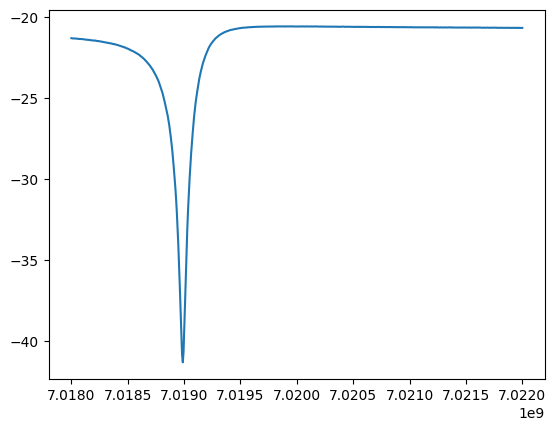

magmin freq= 7018988313.86


In [48]:
mags = np.array([]) 

clear_output(wait=True)
# Esse comando muda a atenuação do switch
#att.attenuation = 10

# Reseta as medidas
#NA.clear_averaging()
#time.sleep(15) #800

# Esse comando captura os dados do NA e formata em array numpy de floats
str_data = vna.data_array()
data = np.array(str_data.split(','),'float')
str_freqs = vna.frequency_array()
freqs = np.array(str_freqs.split(','),'float')
mags = np.append(mags,data[0::2])

plt.plot(freqs,mags.T)

plt.pause(0.05)
plt.show()
print("magmin freq=",freqs[np.argmin(mags.T)])

In [45]:
mags0=mags

In [49]:
mags1=mags

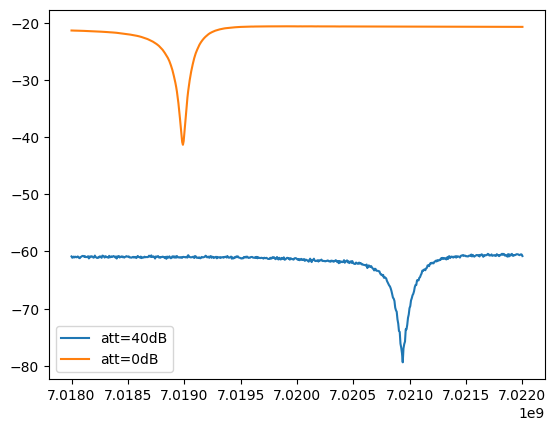

magmin att=40dB freq= 7020938230.38
magmin att=0dB freq= 7018988313.86


In [57]:
plt.plot(freqs,mags0.T,label="att=40dB")
plt.plot(freqs,mags1.T,label="att=0dB")
plt.legend()
plt.show()
print("magmin att=40dB freq=",freqs[np.argmin(mags0.T)])
print("magmin att=0dB freq=",freqs[np.argmin(mags1.T)])

## PowerSweep

In [86]:
start = 7.018*1e9
stop = 7.022 *1e9
f_c = (stop+start)/2
span_f = stop-start
n_freqs = 1000
if_bandwidth = 500

vna.power = 0
vna.data_array_format = 'MLOG'
vna.clear_averaging()

vna.average_points = 512
vna.averaging = 1
#NA.set_amplitude(power)

vna.center_frequency = f_c
vna.span_frequency = span_f
vna.if_bandwidth_frequency = if_bandwidth
vna.sweep_points = n_freqs
vna.autoscale(1)

vna.power = 1

#queries vna until it's not busy
vna.query('*OPC?')


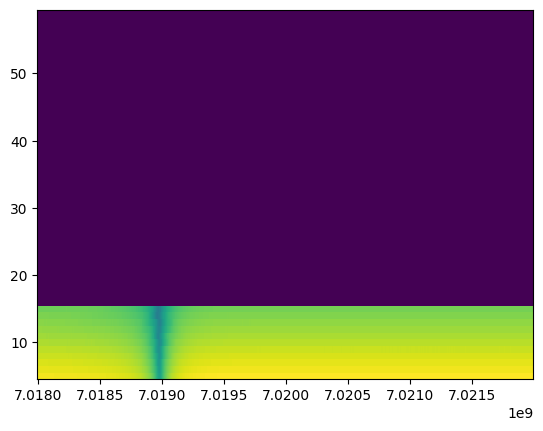

KeyboardInterrupt: 

In [89]:
# Obtém a data e hora atuais
agora = datetime.now()
name = agora.strftime("PowerSweep_2QTII__%Y_%m_%d__%H_%M_%S")
howtoplot = "\
    data = np.load('"+name+".npz')\n\
    attenuations = data['Att']\n\
    freqs = data['Freq']\n\
    mags = data['Mag']\n\
    phases = data['Phase']"


Freq = np.arange(start,stop,(stop-start)/n_freqs)
Att = np.arange(5,60,1)

Mag = np.empty((len(Att), len(Freq)))  #[[] for _ in range(len(freqs))]
Phase = np.empty((len(Att), len(Freq)))  #[[] for _ in range(len(freqs))]
Mag.fill(np.nan) #fills shape of the matrix with empty values
Phase.fill(np.nan)


#Loop de Medidas
for  j, att in enumerate(Att):
    inst_att.set_attenuation(att)
    vna.clear_averaging()

    #queries vna and attenuator until theyre not busy
    #vna.query('*OPC?')
    #inst_att.query('*OPC?')
    sleep(5)
    
    # Limpa o gráfico atual
    #plt.gcf().clear()
    clear_output(wait=True)

    # Esse comando captura os dados do NA e formata em array numpy de floats
    str_data = vna.data_array()
    data = np.array(str_data.split(','),'float')    
    
    #mags = data[0::2]
    mags = data[::2] # slices vector in 2 by 2 steps

    Mag[j][:] = mags
        
    plt.pcolor(Freq,Att,Mag)
    plt.pause(0.05)
    #plt.show()

np.savez(name,header=howtoplot,Att=Att,Freq=Freq,Mag=Mag,Phase=Phase)

print(name)

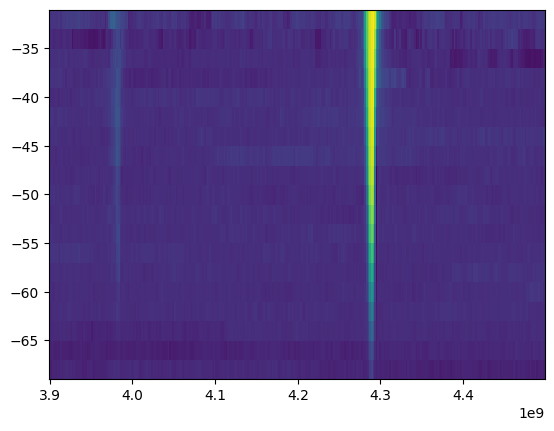

In [1182]:
dados = np.load('PowerSweep_2QTII__2024_09_09__16_45_45.npz')
dados["header"]
attenuations = dados['Amp']
freqs = dados['Freq']
mags = dados['Mag']
phases = dados['Phase']
plt.pcolor(freqs,attenuations,mags)

## TWOTONE

In [ ]:
# Obtém a data e hora atuais
agora = datetime.now()
name = agora.strftime("TWOTONE_SWEEP_3QTII__%Y_%m_%d__%H_%M_%S")
howtoplot = "\
    data = np.load('"+name+".npz')\n\
    attenuations = data['Att']\n\
    freqs = data['Freq']\n\
    mags = data['Mag']\n\
    phases = data['Phase']"

inst_att.set_attenuation(50)
source.amplitude = -16
source.start()
freqs = np.arange(3900,4500,1)*1e6

Freq = np.empty(len(freqs))
Mag = np.empty(len(freqs))  #[[] for _ in range(len(freqs))]
Phase = np.empty(len(freqs))  #[[] for _ in range(len(freqs))]
str_data = NA.data_array()


#Set Inicial para o Plot Iterativo
for i, freq in enumerate(freqs):
    Freq[i] = freq
    Mag[i] = -50
    Phase[i] = 0


NA.data_array_format = 'PLOG'
#Loop de Medidas

for i, freq in enumerate(freqs):
    clear_output(wait=True)

    source.frequency = freq
    NA.clear_averaging()
    time.sleep(3)
    str_data = NA.data_array()
    data = np.array(str_data.split(','),'float')

    mag = np.mean(data[::2])
    phase= data[1::2][int(len(data[::2])/2)]

    
    Mag[i] = mag
    Phase[i] = phase

    # Limpa o gráfico atual

    clear_output(wait=True)
    
    plt.plot(Freq,Mag,'bo-',linewidth=1, markersize=3)
    plt.pause(0.05)

source.stop()
np.savez(name,header=howtoplot,Freq=Freq,Mag=Mag,Phase=Phase)

print(name)

# MEDIDAS PULSADAS

### Cavidade

A ideia principal dessa medida é gerar apenas um pulso. Fazendo a varredura em frequência, se obtém a ressonância da cavidade.

In [18]:
# Define-se um pulso Zero
p1 = ZeroPulse(length = RFMeasurementLength)

In [161]:
SquarePulse?

Init signature: SquarePulse(length, amplitude=1)
Docstring:      This class defines an absctract class that is the bases for all waveforms sent do AWG.
File:           c:\users\franscisco rouxinol\developer\measurementlfdq\src\measurements\waveforms\squarepulse.py
Type:           ABCMeta
Subclasses:     

In [19]:
s1 = PulseSequence('Cavidade', 1e-6)

In [20]:
s1.clear()

s1.add(p = p1, channel = 'm')

Adicionando os pulsos no PulseSequence, vai criar a seguinte estrutura de dados

In [21]:
s1.channels

{'m': {'pulses': array([<measurements.waveforms.ZeroPulse.ZeroPulse object at 0x00000296D482EE10>],
        dtype=object),
  'delays': array([1.e-10]),
  'relative_delays': array([-5.0001e-06])}}

O DataChannelManager recebe uma Pulse Sequence e o converte em formato adequado para o AWG

In [22]:
ms.prepareChannelData(sequence = s1, totalExperimentDuration = 100e-6)

Com isso foi a criada a seguinte estratura de dados

In [37]:
ms._channelData

{'channels': {'m': {'awgChannel': 1,
   'pulse_stream': array([0, 2, 0, ..., 2, 0, 0], dtype=int8),
   'length': 320256,
   'relative_memory_index': 160256}},
 'startupInstrumentIndex': 192256,
 'totalSizeMeasurement': 3200000,
 'awgRate': 32000000000.0}

Próximo passo é liberar a memória do awg e alocar a memória calculada em prepareChannelData

In [23]:
inst_awg.freeMemory()

In [24]:
ms.allocAwgMemory()

Para checar possíveis erros chame getError

In [25]:
inst_awg.getError()

Para carregar os dados de _channelData no canal m chame loadChannelDataToAwg

In [26]:
# Para car
ms.loadChannelDataToAwg('m')

In [27]:
# Atualiza o marker da fonte de excitação
ms.setInstrumentsMarker(1)

## CAVIDADE

In [29]:
inst_awg.stop()
inst_RFsourceMeasurement.stop_rf()

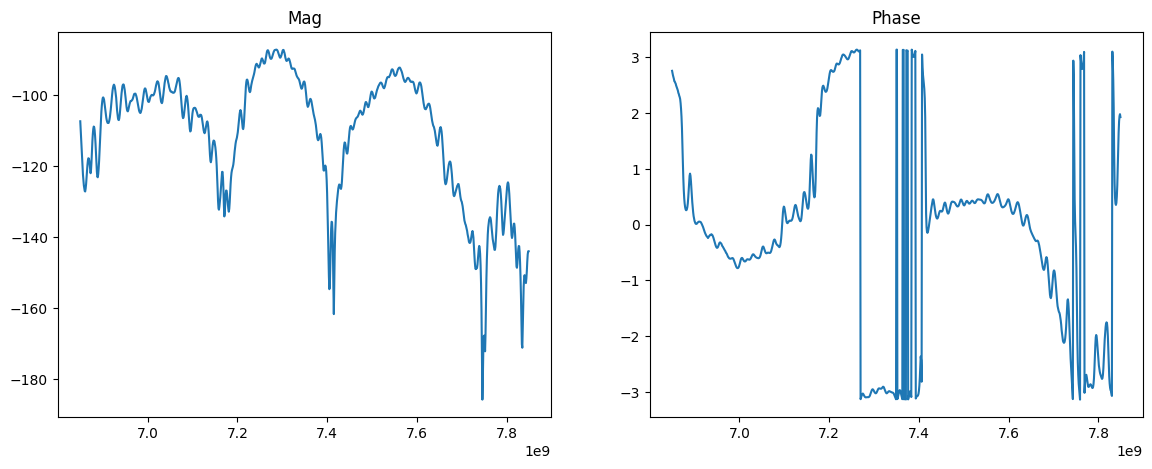

In [30]:
from IPython.display import clear_output

# Obtém a data e hora atuais
agora = datetime.now()
name = agora.strftime("MedidaFundo_Pulsado_L6_%Y_%m_%d__%H_%M_%S")
howtoplot = "\
    data = np.load('"+name+".npz')\n\
    freqs = data['Freq']\n\
    mags = data['Mag']\n\
    phases = data['Phase']"


alazar_params['recordsPerBuffer'] = 250  # número de capturas por buffer.
alazar_params['buffersPerAcquisition'] = 100 # número de buffers por aquisição.
inst_att.set_attenuation(25)
freqs = np.arange(6850,7850,1)*1e6

Freq = []
Mag = []
Phase = []

for i, freq in enumerate(freqs):
    Mag.append(-50)
    Phase.append(0)
    Freq.append(freq)

inst_awg.start()
inst_RFsourceMeasurement.start_rf()
sleep(1)

for  i, freq in enumerate(freqs):

    inst_RFsourceMeasurement.set_frequency(freq-240e6)
    #inst_RFsourceMeasurement.query('*OPC?') #synchronize instrument to python with a query
    sleep(0.05)

    I,Q = capture()
    Mag[i] = 20*np.log(np.sqrt(I**2+Q**2))
    Phase[i] = np.arctan2(Q, I)

    # Limpa o gráfico atual
    #plt.gcf().clear()
    clear_output(wait=True)
    #plt.plot(Freq,Mag)

    fig, ax = plt.subplots(1,2,figsize=(14, 5))
    ax[1].set_title("Phase")
    ax[1].plot(Freq,Phase)
    ax[0].set_title("Mag")
    ax[0].plot(Freq,Mag)

    plt.pause(0.05)
    #plt.show()

    np.savez(name,header=howtoplot,Freq=Freq,Mag=Mag,Phase=Phase)

inst_awg.stop()
inst_RFsourceMeasurement.stop_rf()

# PowerSweep

In [152]:
inst_awg.start()

In [153]:
inst_RFsourceMeasurement.start_rf()

In [154]:
alazar_params['recordsPerBuffer'] = 500  # número de capturas por buffer.
alazar_params['buffersPerAcquisition'] = 100 # número de buffers por aquisição.

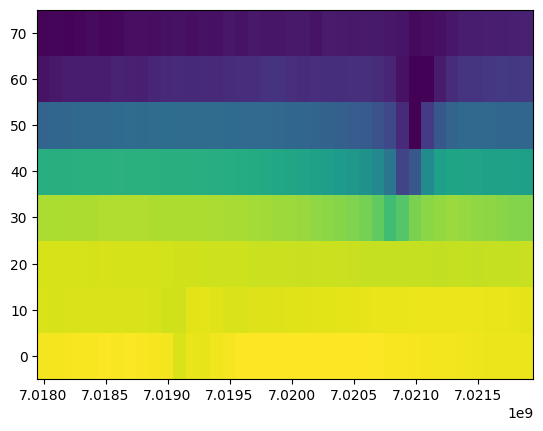

PowerSweep_3QTII__2024_08_29__19_23_55


In [869]:
# Obtém a data e hora atuais
agora = datetime.now()
name = agora.strftime("PowerSweep_3QTII__%Y_%m_%d__%H_%M_%S")
howtoplot = "\
    data = np.load('"+name+".npz')\n\
    attenuations = data['Att']\n\
    freqs = data['Freq']\n\
    mags = data['Mag']\n\
    phases = data['Phase']"


freqs = np.arange(7018,7022,0.1)*1e6
atts = np.arange(0,80,10)

Att = np.empty(len(atts))
Freq = np.empty(len(freqs))
Mag = np.empty((len(atts), len(freqs)))  #[[] for _ in range(len(freqs))]
Phase = np.empty((len(atts), len(freqs)))  #[[] for _ in range(len(freqs))]

inst_awg.start()
inst_RFsourceMeasurement.start_rf()
sleep(1)

#Set Inicial para o Plot Iterativo
for i, freq in enumerate(freqs):
    Freq[i] = freq

for  j, att in enumerate(atts):
    Att[j] = att
    
    for i, freq in enumerate(freqs):
        Mag[j][i] = -100
        Phase[j][i] = 0



#Loop de Medidas
for  j, att in enumerate(atts):
#    inst_att.set_attenuation(att)
    inst_att.set_attenuation(att)
    for i, freq in enumerate(freqs):

        inst_RFsourceMeasurement.set_frequency(freq-240e6)
        sleep(0.05)
    
        I,Q = capture()
        Mag[j][i] = 20*np.log(np.sqrt(I**2+Q**2))
        Phase[j][i] = np.arctan2(Q, I)
    
        # Limpa o gráfico atual
        #plt.gcf().clear()
        clear_output(wait=True)
        
        plt.pcolor(Freq,Att,Mag)
        plt.pause(0.05)
        #plt.show()

    np.savez(name,header=howtoplot,Att=Att,Freq=Freq,Mag=Mag,Phase=Phase)

inst_RFsourceMeasurement.stop_rf()
inst_awg.stop()
print(name)

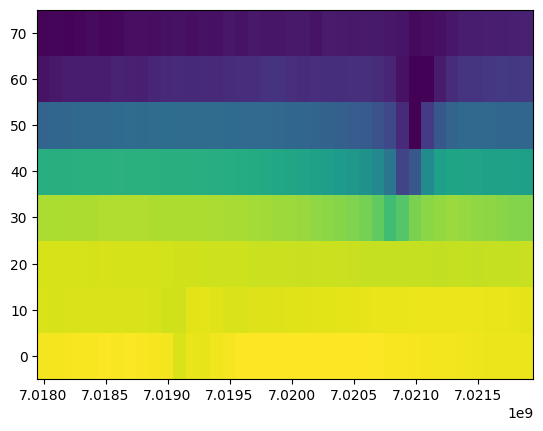

In [870]:
dados = np.load('PowerSweep_3QTII__2024_08_29__19_23_55.npz')
dados["header"]
attenuations = dados['Att']
freqs = dados['Freq']
mags = dados['Mag']
phases = dados['Phase']
plt.pcolor(freqs,attenuations,mags)

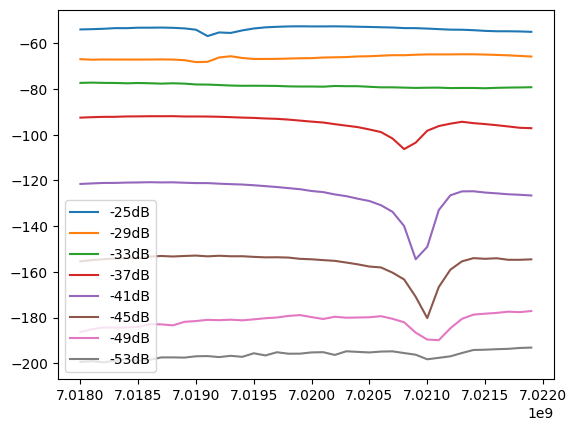

In [871]:
plt.plot(freqs,mags[0],label='-25dB')
plt.plot(freqs,mags[1]-10,label='-29dB')
plt.plot(freqs,mags[2]-20,label='-33dB')
plt.plot(freqs,mags[3]-30,label='-37dB')
plt.plot(freqs,mags[4]-40,label='-41dB')
plt.plot(freqs,mags[5]-50,label='-45dB')
plt.plot(freqs,mags[6]-60,label='-49dB')
plt.plot(freqs,mags[7]-70,label='-53dB')
plt.legend()

## TWOTONE

In [224]:
SquarePulse?

Init signature: SquarePulse(length, amplitude=1)
Docstring:      This class defines an absctract class that is the bases for all waveforms sent do AWG.
File:           c:\users\franscisco rouxinol\developer\measurementlfdq\src\measurements\waveforms\squarepulse.py
Type:           ABCMeta
Subclasses:     

In [243]:
PulseSequence?

Init signature: PulseSequence(name, startup_delay)
Docstring:     
This class allows one to synchronize the any number of pulses for different channels.

A channel is just a label. It will be used by the DataChannelManager to build the array of bytes
that will be loaded into AWG. 
Init docstring:
Init the pulse sequence.
name: name of this sequence of pulses.

The self.channels is a dict, where channel will one of its keys.

self.channels[channel.lower()] is also dict that holds three keys: pulses, delays and relative delays

self.channels[channel.lower()]['pulses'] is a list of pulses instances in the channel
self.channels[channel.lower()]['delays'] is a list of delays of each pulse in the channel
self.channels[channel.lower()]['relative_delays'] is the starting time of pulse in relation to the end of the pulse sequence.
for example, let the sequence in channel 'I' have two pulses, P1 and P2, with delay of 5 microseconds between them, and 2 microsecond after P2.
P1 has 1 microsecond o

In [952]:
inst_awg.stop()

# Define-se um pulso Zero
p1 = SquarePulse(length = 1e-6, amplitude = 0.8)
#p1 = GaussianPulse(length = 20e-6, amplitude = 1, sigma = 4e-6)
p2 = ZeroPulse(length = RFMeasurementLength)

s1 = PulseSequence('Twotone', 10e-9)

s1.clear()

s1.add(p = p1, channel = 'I', delay = RFMeasurementLength)
s1.add(p = p2, channel = 'm')


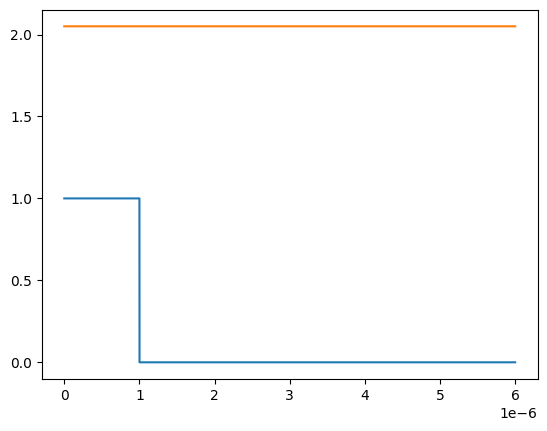

In [756]:
s1.show_all()

In [75]:
ms.prepareChannelData(sequence = s1, totalExperimentDuration = 200e-6)

inst_awg.freeMemory()

ms.allocAwgMemory()
sleep(0.05)
ms.loadChannelDataToAwg('I')
sleep(0.05)
ms.loadChannelDataToAwg('m')
sleep(0.05)

# Atualiza o marker da fonte de excitação
ms.setInstrumentsMarker(1)

In [953]:
ms.prepareChannelData(sequence = s1, totalExperimentDuration = 200e-6)

In [954]:
inst_awg.freeMemory()

In [955]:
ms.allocAwgMemory()

In [956]:
ms.loadChannelDataToAwg('I')

In [957]:
ms.loadChannelDataToAwg('m')

In [958]:
ms.setInstrumentsMarker(1)

In [959]:
inst_awg.getError()

In [960]:
inst_awg.start()

In [252]:
from IPython.display import clear_output

In [881]:
inst_awg.stop()
inst_RFsourceMeasurement.stop_rf()
inst_RFsourceExcitation.stop_rf()

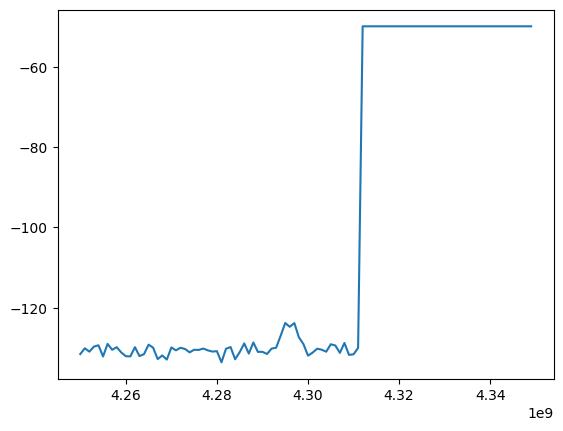

KeyboardInterrupt: 

In [1031]:
agora = datetime.now()
name = agora.strftime("TWOTONE_3QTII_ExctQubit_%Y_%m_%d__%H_%M_%S")
howtoplot = "\
    data = np.load('"+name+".npz')\n\
    attenuations = data['Att']\n\
    freqs = data['Freq']\n\
    mags = data['Mag']\n\
    phases = data['Phase']"

alazar_params['recordsPerBuffer'] = 100  # número de capturas por buffer.
alazar_params['buffersPerAcquisition'] = 100 # número de buffers por aquisição.
inst_att.set_attenuation(50)
inst_RFsourceMeasurement.set_frequency(7.021e9-240e6)
inst_RFsourceMeasurement.set_amplitude(18)
inst_RFsourceExcitation.set_amplitude(11)
freqs = np.arange(4250,4350,1)*1e6


Freq = []
Mag = []
Phase = []

for i, freq in enumerate(freqs):
    Mag.append(-50)
    Phase.append(0)
    Freq.append(freq)

inst_awg.start()
inst_RFsourceMeasurement.start_rf()
inst_RFsourceExcitation.start_rf()
sleep(1)

for  i, freq in enumerate(freqs):

    inst_RFsourceExcitation.set_frequency(freq)
    sleep(0.05)

    I,Q = capture()
    Mag[i] = 20*np.log(np.sqrt(I**2+Q**2))
    Phase[i] = np.arctan2(Q, I)

    # Limpa o gráfico atual
    #plt.gcf().clear()
    clear_output(wait=True)
    #plt.plot(Freq,Mag)

    #fig, ax = plt.subplots(1,2,figsize=(14, 5))
    #ax[1].set_title("Phase")
    #ax[1].plot(Freq,Phase)
    #ax[0].set_title("Mag")
    #ax[0].plot(Freq,Mag)
    plt.plot(Freq,Mag)
    plt.pause(0.05)
    #plt.show()
    np.savez(name,header=howtoplot,Freq=Freq,Mag=Mag,Phase=Phase)

print(name)
inst_awg.stop()
inst_RFsourceMeasurement.stop_rf()
inst_RFsourceExcitation.stop_rf()

TWOTONE_3QTII_ExctQubit_2024_08_29__20_48_17.npz


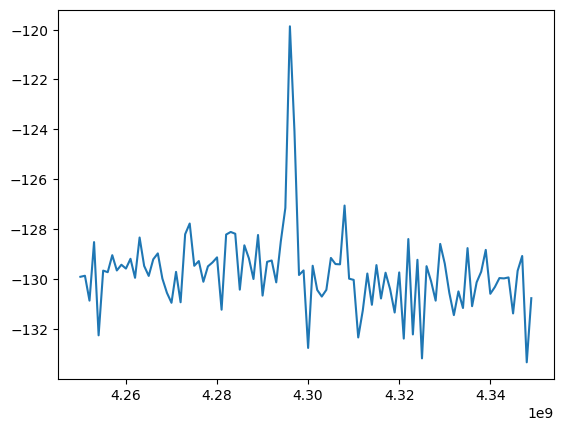

In [1183]:
dados = np.load('TWOTONE_3QTII_ExctQubit_2024_08_29__20_48_17.npz')
dados["header"]
freqs = dados['Freq']
mags = dados['Mag']
phases = dados['Phase']
plt.plot(freqs,mags)
#plt.vlines(4.2961e9,-120,-130,color = 'red')
print('TWOTONE_3QTII_ExctQubit_2024_08_29__20_48_17.npz')

In [894]:
inst_awg.stop()
inst_RFsourceMeasurement.stop_rf()
inst_RFsourceExcitation.stop_rf()

In [427]:
inst_RFsourceMeasurement.set_frequency(7.02e9-70e6)
inst_RFsourceMeasurement.start_rf()

In [441]:
inst_RFsourceMeasurement.start_rf()

In [445]:
4-7-60-60-4+35+35+30

-27

In [432]:
inst_RFsourceMeasurement.set_amplitude(16)

In [431]:
inst_att.set_attenuation(5)

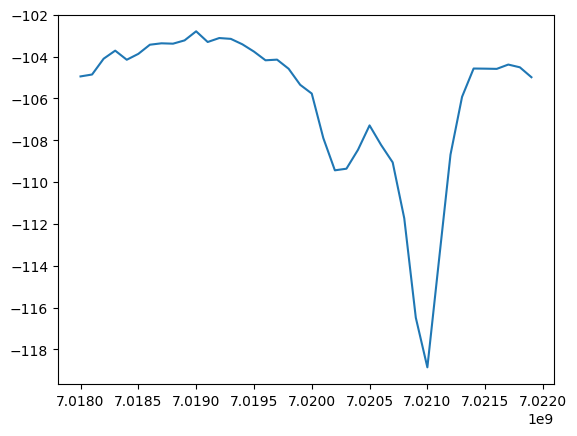

TWOTONE_3QTII_ExctQubit_2024_08_29__20_36_14


In [927]:
agora = datetime.now()
name = agora.strftime("TWOTONE_3QTII_ExctQubit_%Y_%m_%d__%H_%M_%S")
howtoplot = "\
    data = np.load('"+name+".npz')\n\
    attenuations = data['Att']\n\
    freqs = data['Freq']\n\
    mags = data['Mag']\n\
    phases = data['Phase']"

alazar_params['recordsPerBuffer'] = 250  # número de capturas por buffer.
alazar_params['buffersPerAcquisition'] = 100 # número de buffers por aquisição.
inst_att.set_attenuation(50)
#inst_RFsourceMeasurement.set_frequency(7.020899e9-70e6)
inst_RFsourceExcitation.set_frequency(4.297e9)
inst_RFsourceMeasurement.set_amplitude(18)
inst_RFsourceExcitation.set_amplitude(11)
freqs = np.arange(7018,7022,0.1)*1e6


Freq = []
Mag = []
Phase = []

for i, freq in enumerate(freqs):
    Mag.append(-50)
    Phase.append(0)
    Freq.append(freq)

inst_awg.start()
inst_RFsourceMeasurement.start_rf()
inst_RFsourceExcitation.start_rf()
sleep(1)

for  i, freq in enumerate(freqs):

    inst_RFsourceMeasurement.set_frequency(freq-240e6)
    sleep(0.05)

    I,Q = capture()
    Mag[i] = 20*np.log(np.sqrt(I**2+Q**2))
    Phase[i] = np.arctan2(Q, I)

    # Limpa o gráfico atual
    #plt.gcf().clear()
    clear_output(wait=True)
    #plt.plot(Freq,Mag)

    #fig, ax = plt.subplots(1,2,figsize=(14, 5))
    #ax[1].set_title("Phase")
    #ax[1].plot(Freq,Phase)
    #ax[0].set_title("Mag")
    #ax[0].plot(Freq,Mag)
    plt.plot(Freq,Mag)
    plt.pause(0.05)
    #plt.show()
    np.savez(name,header=howtoplot,Freq=Freq,Mag=Mag,Phase=Phase)

print(name)
inst_awg.stop()
inst_RFsourceMeasurement.stop_rf()
inst_RFsourceExcitation.stop_rf()

TWOTONE_3QTII_ExctQubit_2024_08_29__20_36_14.npz


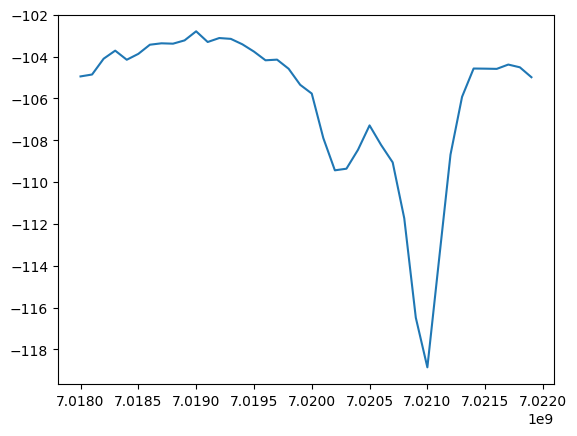

In [928]:
dados = np.load('TWOTONE_3QTII_ExctQubit_2024_08_29__20_36_14.npz')
dados["header"]
freqs = dados['Freq']
mags = dados['Mag']
phases = dados['Phase']
plt.plot(freqs,mags)
print('TWOTONE_3QTII_ExctQubit_2024_08_29__20_36_14.npz')

In [930]:
mag6 = Mag

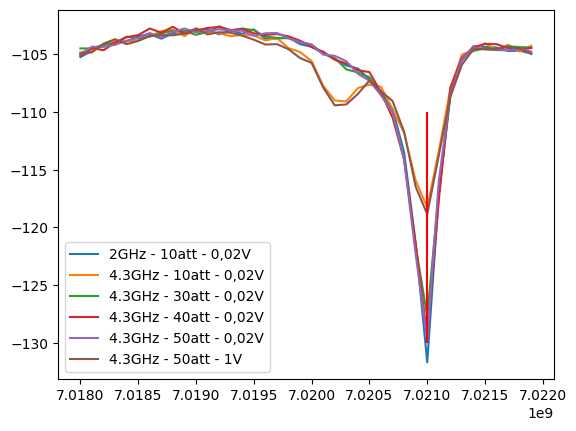

In [948]:
plt.plot(Freq,mag1,label = '2GHz - 10att - 0,02V')
plt.plot(Freq,mag2,label = '4.3GHz - 10att - 0,02V')
plt.plot(Freq,mag3,label = '4.3GHz - 30att - 0,02V')
plt.plot(Freq,mag4, label = '4.3GHz - 40att - 0,02V')
plt.plot(Freq,mag5, label = '4.3GHz - 50att - 0,02V')
plt.plot(Freq,mag6, label = '4.3GHz - 50att - 1V')
#plt.plot(Freq,np.array(mag7)+40, label = '4.3GHz-10att-0.2V')
#plt.plot(Freq,np.array(mag9)-40, label = '4.3GHz-10att-0.05V')
#plt.plot(Freq,np.array(mag10)-20, label = '4GHz-10att-0.1V')
#plt.plot(Freq,np.array(mag11)-20, label = '4.3GHz-10att-0.1V')
#plt.plot(Freq,np.array(mag9)-20, label = '4.3GHz-10att-0.05V')
plt.legend()
plt.vlines(7.021e9,-110,-130,color='red')

# Rabi

In [1041]:
inst_awg.stop()

# Define-se um pulso Zero
p1 = SquarePulse(length = 0, amplitude = 1)
p2 = ZeroPulse(length = RFMeasurementLength)

s1 = PulseSequence('Twotone', 10e-9)

s1.clear()

s1.add(p = p1, channel = 'I', delay = RFMeasurementLength)
s1.add(p = p2, channel = 'm')


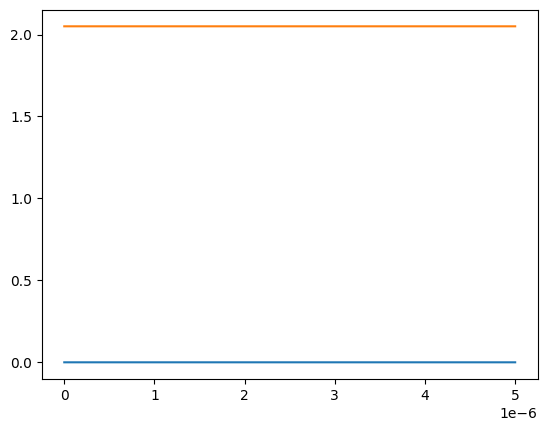

In [991]:
s1.show_all()

In [239]:
ms.prepareChannelData(sequence = s1, totalExperimentDuration = 120e-6)

inst_awg.freeMemory()

ms.allocAwgMemory()
sleep(0.05)
ms.loadChannelDataToAwg('I')
sleep(0.05)
ms.loadChannelDataToAwg('m')
sleep(0.05)

# Atualiza o marker da fonte de excitação
ms.setInstrumentsMarker(1)

In [1042]:
ms.prepareChannelData(sequence = s1, totalExperimentDuration = 500e-6)

In [1043]:
inst_awg.freeMemory()

In [1044]:
ms.allocAwgMemory()

In [1045]:
ms.loadChannelDataToAwg('I')

In [1046]:
ms.loadChannelDataToAwg('m')

In [1047]:
ms.setInstrumentsMarker(1)

In [1048]:
inst_awg.start()

In [1025]:
inst_awg.stop()

In [479]:
p1.length = 0

s1.clear()

s1.add(p = p1, channel = 'I', delay = RFMeasurementLength)
s1.add(p = p2, channel = 'm')

In [572]:
durations = np.arange(0,2000e-9,250e-9)

Durat = []
Mag = []
Phase = []

for i, duration in enumerate(durations):
    Mag.append(-50)
    Phase.append(0)
    Durat.append(duration)

for duration in durations:

    p1.length = duration
    
    s1.clear()

    s1.add(p = p1, channel = 'I', delay = RFMeasurementLength)
    s1.add(p = p2, channel = 'm')

    ms.updateChannelData(sequence = s1, channelName = 'I')
    sleep(0.05)
    ms.loadChannelDataToAwg('I')
    sleep(0.05)
    ms.loadChannelDataToAwg('m')
    sleep(0.05)
    ms.setInstrumentsMarker(1)
    sleep(0.5)






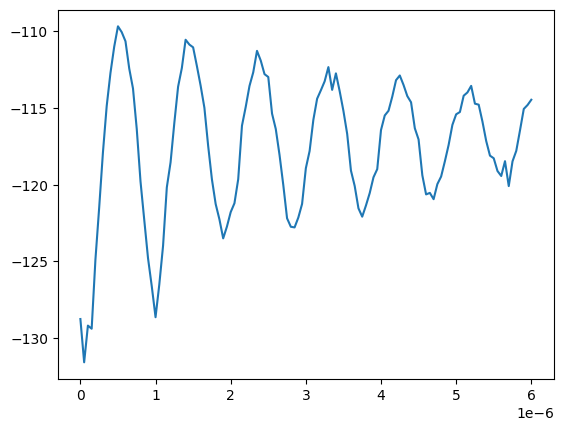

TWOTONE_3QTII_ExctQubit_2024_08_29__22_55_48


In [1049]:
agora = datetime.now()
name = agora.strftime("TWOTONE_3QTII_ExctQubit_%Y_%m_%d__%H_%M_%S")
howtoplot = "\
    data = np.load('"+name+".npz')\n\
    attenuations = data['Att']\n\
    freqs = data['Freq']\n\
    mags = data['Mag']\n\
    phases = data['Phase']"

alazar_params['recordsPerBuffer'] = 250  # número de capturas por buffer.
alazar_params['buffersPerAcquisition'] = 100 # número de buffers por aquisição.
inst_att.set_attenuation(50)
inst_RFsourceMeasurement.set_frequency(7.021e9-240e6)
inst_RFsourceExcitation.set_frequency(4.2961e9) # mudar este aqui para o mapa de rabi gustavo: dentro do for 
inst_RFsourceMeasurement.set_amplitude(18)
inst_RFsourceExcitation.set_amplitude(11)
durations = np.arange(0,6000e-9,50e-9)

Durat = []
Mag = []
Phase = []

for i, duration in enumerate(durations):
    Mag.append(-115)
    Phase.append(0)
    Durat.append(duration)

inst_awg.start()
inst_RFsourceMeasurement.start_rf()
inst_RFsourceExcitation.start_rf()
sleep(1)


for i, duration in enumerate(durations):

    p1.length = duration
    
    s1.clear()

    s1.add(p = p1, channel = 'I', delay = RFMeasurementLength)
    s1.add(p = p2, channel = 'm')

    ms.updateChannelData(sequence = s1, channelName = 'I')
    sleep(0.5)
    ms.loadChannelDataToAwg('I')
    sleep(0.5)
    ms.loadChannelDataToAwg('m')
    sleep(0.5)
    ms.setInstrumentsMarker(1)
    sleep(0.5)

    I,Q = capture()
    sleep(0.5)
    Mag[i] = 20*np.log(np.sqrt(I**2+Q**2))
    Phase[i] = np.arctan2(Q, I)

    # Limpa o gráfico atual
    #plt.gcf().clear()
    clear_output(wait=True)
    #plt.plot(Freq,Mag)

    #fig, ax = plt.subplots(1,2,figsize=(14, 5))
    #ax[1].set_title("Phase")
    #ax[1].plot(Freq,Phase)
    #ax[0].set_title("Mag")
    #ax[0].plot(Freq,Mag)
    plt.plot(Durat,Mag)
    plt.pause(0.05)
    #plt.show()
    np.savez(name,header=howtoplot,Delay=Delay,Mag=Mag,Phase=Phase)

print(name)
inst_awg.stop()
inst_RFsourceMeasurement.stop_rf()
inst_RFsourceExcitation.stop_rf()

In [743]:
inst_awg.stop()
inst_RFsourceMeasurement.stop_rf()
inst_RFsourceExcitation.stop_rf()

In [1074]:
print(Delay)

[0.e+00 2.e-07 4.e-07 6.e-07 8.e-07]


TWOTONE_3QTII_ExctQubit_2024_08_29__22_55_48.npz


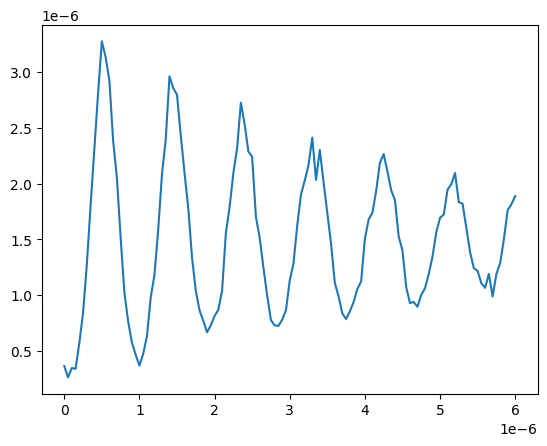

In [1184]:
dados = np.load('TWOTONE_3QTII_ExctQubit_2024_08_29__22_55_48.npz')
dados["header"]
Delay = dados['Delay']
mags = dados['Mag']
mags = 10**(mags/20)
phases = dados['Phase']
plt.plot(Durat,mags)
#plt.vlines(0.525e-6,-110,-130)
print('TWOTONE_3QTII_ExctQubit_2024_08_29__22_55_48.npz')

## Map

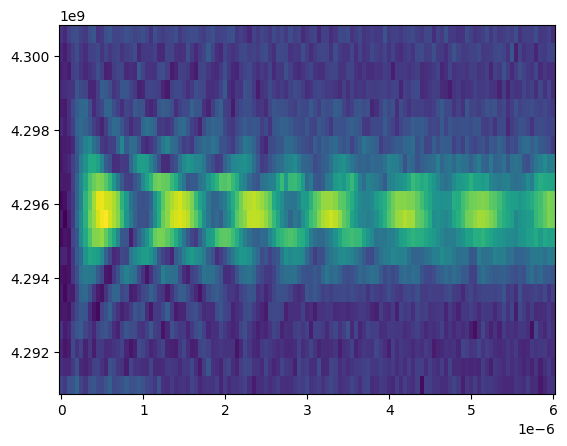

ChevronRabi_3QTII__2024_08_30__00_59_19


In [1066]:
# Obtém a data e hora atuais
agora = datetime.now()
name = agora.strftime("ChevronRabi_3QTII__%Y_%m_%d__%H_%M_%S")
howtoplot = "\
    data = np.load('"+name+".npz')\n\
    attenuations = data['Att']\n\
    freqs = data['Freq']\n\
    mags = data['Mag']\n\
    phases = data['Phase']"

alazar_params['recordsPerBuffer'] = 250  # número de capturas por buffer.
alazar_params['buffersPerAcquisition'] = 100 # número de buffers por aquisição.
inst_att.set_attenuation(50)
inst_RFsourceMeasurement.set_frequency(7.021e9-240e6)
#inst_RFsourceExcitation.set_frequency(4.2961e9) # mudar este aqui para o mapa de rabi gustavo: dentro do for 
inst_RFsourceMeasurement.set_amplitude(18)
inst_RFsourceExcitation.set_amplitude(11)

freqs = np.arange(4296.1-5,4296.1+5,0.5)*1e6
durations = np.arange(0,6000e-9,50e-9)

Durat = np.empty(len(durations))
Freq = np.empty(len(freqs))
Mag = np.empty((len(freqs), len(durations)))  
Phase = np.empty((len(freqs), len(durations))) 


for  i, dur in enumerate(durations):
    Durat[i] = dur

for  j, freq in enumerate(freqs):
    Freq[j] = freq
    
    for i, dur in enumerate(durations):
        Mag[j][i] = -100
        Phase[j][i] = 0
        

#Loop de Medidas
for  j, freq in enumerate(freqs):
    inst_RFsourceExcitation.set_frequency(freq)
    
    inst_awg.stop()
    inst_RFsourceMeasurement.stop_rf()
    inst_RFsourceExcitation.stop_rf()
    sleep(0.5)
    # Define-se um pulso Zero
    p1 = SquarePulse(length = 0, amplitude = 1)
    p2 = ZeroPulse(length = RFMeasurementLength)
    
    s1 = PulseSequence('Twotone', 10e-9)
    
    s1.clear()
    
    s1.add(p = p1, channel = 'I', delay = RFMeasurementLength)
    s1.add(p = p2, channel = 'm')

    ms.prepareChannelData(sequence = s1, totalExperimentDuration = 500e-6)
    sleep(2)
    inst_awg.freeMemory()
    sleep(0.5)
    ms.allocAwgMemory()
    sleep(0.5)
    ms.loadChannelDataToAwg('I')
    sleep(0.5)
    ms.loadChannelDataToAwg('m')
    sleep(0.5)
    ms.setInstrumentsMarker(1)
    sleep(0.5)

    inst_awg.start()
    inst_RFsourceMeasurement.start_rf()
    inst_RFsourceExcitation.start_rf()
    sleep(1)

    for i, duration in enumerate(durations):

        p1.length = duration
        
        s1.clear()
    
        s1.add(p = p1, channel = 'I', delay = RFMeasurementLength)
        s1.add(p = p2, channel = 'm')
    
        ms.updateChannelData(sequence = s1, channelName = 'I')
        sleep(0.5)
        ms.loadChannelDataToAwg('I')
        sleep(0.5)
        ms.loadChannelDataToAwg('m')
        sleep(0.5)
        ms.setInstrumentsMarker(1)
        sleep(0.5)
    
        I,Q = capture()
        sleep(0.5)
        Mag[j][i] = 20*np.log(np.sqrt(I**2+Q**2))
        Phase[j][i] = np.arctan2(Q, I)
    
        # Limpa o gráfico atual
        #plt.gcf().clear()
        clear_output(wait=True)
        #plt.plot(Freq,Mag)
    
        #fig, ax = plt.subplots(1,2,figsize=(14, 5))
        #ax[1].set_title("Phase")
        #ax[1].plot(Freq,Phase)
        #ax[0].set_title("Mag")
        #ax[0].plot(Freq,Mag)
        plt.pcolor(Durat,Freq,Mag)
        plt.pause(0.05)
        #plt.show()
        np.savez(name,header=howtoplot,Durat=Durat,Mag=Mag,Phase=Phase)
        sleep(0.05)
    
inst_RFsourceMeasurement.stop_rf()
inst_awg.stop()
print(name)

### T1

In [ ]:
p1 = SquarePulse(length =(0.525e-6, amplitude = 1)
p2 = ZeroPulse(length = RFMeasurementLength)

s1 = PulseSequence('Twotone', 10e-9)
    

In [1080]:
inst_awg.stop()

# Define-se um pulso Zero
p1 = SquarePulse(length = 0.525e-6,amplitude = 1)
p2 = ZeroPulse(length = RFMeasurementLength)

s1 = PulseSequence('Twotone', 10e-9)

s1.clear()

s1.add(p = p1, channel = 'I', delay = RFMeasurementLength)
s1.add(p = p2, channel = 'm')


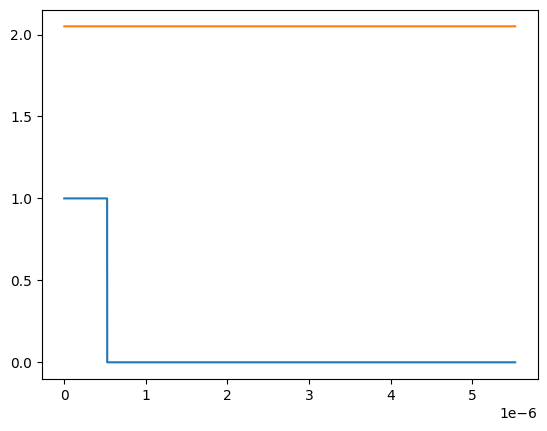

In [1081]:
s1.show_all()

In [136]:
ms.prepareChannelData(sequence = s1, totalExperimentDuration = 200e-6)

In [137]:
inst_awg.freeMemory()

In [138]:
ms.allocAwgMemory()

In [139]:
ms.loadChannelDataToAwg('I')

In [140]:
ms.loadChannelDataToAwg('m')

In [141]:
ms.setInstrumentsMarker(1)

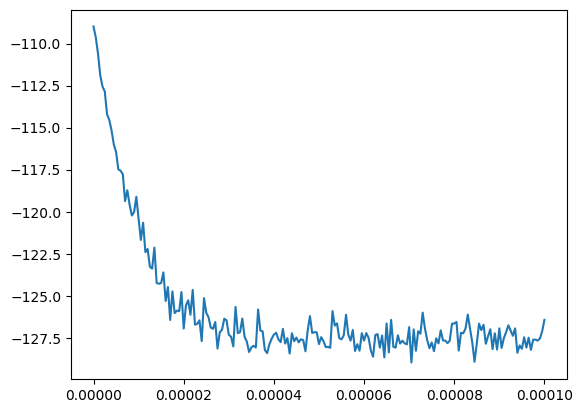

ChevronRabi_3QTII__2024_08_30__15_01_17


In [1086]:
# Obtém a data e hora atuais
agora = datetime.now()
name = agora.strftime("T1_3QTII__%Y_%m_%d__%H_%M_%S")
howtoplot = "\
    data = np.load('"+name+".npz')\n\
    attenuations = data['Att']\n\
    freqs = data['Freq']\n\
    mags = data['Mag']\n\
    phases = data['Phase']"

alazar_params['recordsPerBuffer'] = 250  # número de capturas por buffer.
alazar_params['buffersPerAcquisition'] = 100 # número de buffers por aquisição.
inst_att.set_attenuation(50)
inst_RFsourceMeasurement.set_frequency(7.021e9-240e6)
inst_RFsourceExcitation.set_frequency(4.2961e9) # mudar este aqui para o mapa de rabi gustavo: dentro do for 
inst_RFsourceMeasurement.set_amplitude(18)
inst_RFsourceExcitation.set_amplitude(11)
PiPulse = 525e-9

delays = np.arange(0,100e-6,500e-9)

Delay = np.empty(len(delays))
Mag = np.empty(len(delays))  
Phase = np.empty(len(delays)) 


for i, delayy in enumerate(delays):
    Delay[i] = delayy
    Mag[i] = -100
    Phase[i] = 0

inst_awg.stop()
inst_RFsourceMeasurement.stop_rf()
inst_RFsourceExcitation.stop_rf()
sleep(0.5)
# Define-se um pulso Zero
p1 = SquarePulse(length = 0.525e-6,amplitude = 1)
p2 = ZeroPulse(length = RFMeasurementLength)

s1 = PulseSequence('Twotone', 10e-9)
s1.clear()

s1.add(p = p1, channel = 'I', delay = RFMeasurementLength)
s1.add(p = p2, channel = 'm')

ms.prepareChannelData(sequence = s1, totalExperimentDuration = 500e-6)
sleep(2)
inst_awg.freeMemory()
sleep(0.5)
ms.allocAwgMemory()
sleep(0.5)
ms.loadChannelDataToAwg('I')
sleep(0.5)
ms.loadChannelDataToAwg('m')
sleep(0.5)
ms.setInstrumentsMarker(1)
sleep(0.5)

inst_awg.start()
inst_RFsourceMeasurement.start_rf()
inst_RFsourceExcitation.start_rf()
sleep(1)

#Loop de Medidas
for i, delayy in enumerate(delays):

    s1.clear()
    s1.add(p = p1, channel = 'I', delay = RFMeasurementLength+delayy)
    s1.add(p = p2, channel = 'm')
    ms.updateChannelData(sequence = s1, channelName = 'I')
    sleep(0.5)
    ms.loadChannelDataToAwg('I') # Quando usa o canal Q, não precisa atualizar o m, a menos que haja alteração de dados no canal m
    sleep(0.5)
    ms.loadChannelDataToAwg('m')
    sleep(0.5)
    ms.setInstrumentsMarker(1)
    sleep(0.5)

    I,Q = capture()
    sleep(0.5)
    Mag[i] = 20*np.log(np.sqrt(I**2+Q**2))
    Phase[i] = np.arctan2(Q, I)

    # Limpa o gráfico atual
    #plt.gcf().clear()
    clear_output(wait=True)
    #plt.plot(Freq,Mag)

    #fig, ax = plt.subplots(1,2,figsize=(14, 5))
    #ax[1].set_title("Phase")
    #ax[1].plot(Freq,Phase)
    #ax[0].set_title("Mag")
    #ax[0].plot(Freq,Mag)
    plt.plot(Delay,Mag)
    plt.pause(0.05)
    #plt.show()
    np.savez(name,header=howtoplot,Delay=Delay,Mag=Mag,Phase=Phase)
    sleep(0.05)
    
inst_RFsourceMeasurement.stop_rf()
inst_awg.stop()
print(name)

ChevronRabi_3QTII__2024_08_30__15_01_17.npz


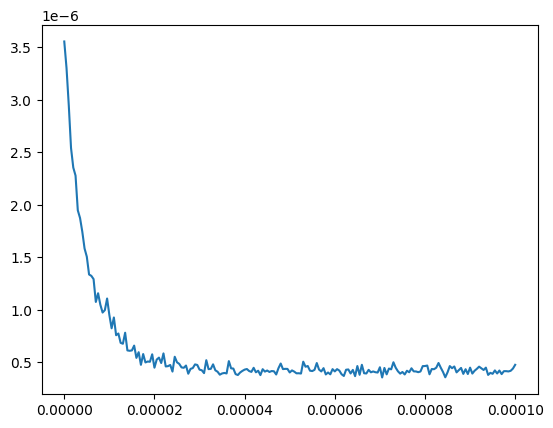

In [1157]:
dados = np.load('ChevronRabi_3QTII__2024_08_30__15_01_17.npz')
dados["header"]
Delay = dados['Delay']
Mag = dados['Mag']
Mag = 10**(Mag/20)
Phase = dados['Phase']
plt.plot(Delay,Mag)
#plt.vlines(0.525e-6,-110,-130)
print('ChevronRabi_3QTII__2024_08_30__15_01_17.npz')

In [1089]:
def T1(time, Const, Slope, T):   
    """
    Rabi curve using exponential decay: Const + Slope*exp(-time/Tr)*cos(2*pi*time/Period+Phase)

    """
    return (Const + Slope*np.exp(-time/T))

def T1_g(time, Const,Const1, Slope, T):
    """
    Rabi curve using gaussianan decay: Const + amp * N.exp(-0.5*((x-pos)/(wid))**2)

    """
    return (Const + Slope*np.exp(-0.5*(time+Const1)/T)**2)


In [1158]:
# T1 exponential

from scipy.optimize import curve_fit
args_T1 = [0.0033,-0.002,21e-6] # initial parameter to fit
#"""
#[Const, Slope,T1]{Const + Slope*exp(-time/T1)}
#"""
popt,pcov = curve_fit(T1, Delay, Mag, p0=args_T1)   
#print(r'T1 (Exponential): {0:.2f} +- {1:.2f} µs'.format(popt[2]*1e6,pcov[2]*1e6))

In [1159]:
perr = np.sqrt(np.diag(pcov))
print( popt[2]*1e6, perr[2]*1e6 )

5.082576635887936 0.07259722716323792


In [1160]:
print( popt[2]*1e6, perr[2]*1e6 )

5.082576635887936 0.07259722716323792


Text(0.5, 1.0, '$T_1$ Measurement')

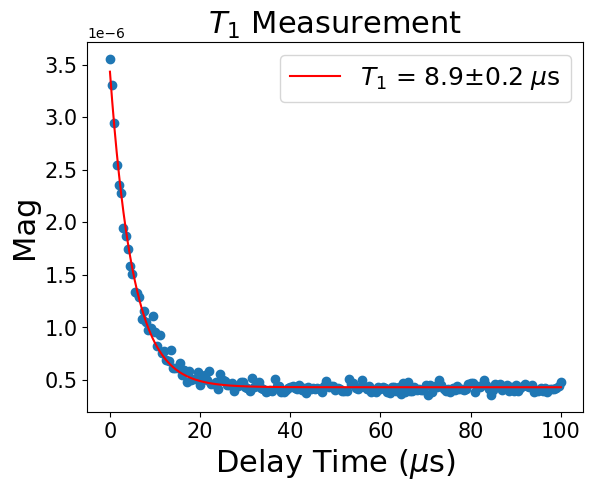

In [1161]:
plt.scatter(Delay*1e6,Mag)
plt.plot(Delay*1e6,T1(Delay,*popt), label = "$T_1$ = 8.9$\pm$0.2 $\mu$s", color = "red")
plt.legend(prop={"size":18})
plt.xlabel("Delay Time ($\mu$s)", fontsize=22)
plt.xticks(fontsize = 15)
plt.ylabel("Mag", fontsize=22)
plt.yticks(fontsize = 15)
#plt.legend()
plt.title("$T_1$ Measurement", fontsize=22)

### Ramsey

In [43]:
inst_awg.stop()

# Define-se um pulso Zero
p1 = SquarePulse(length = 25e-9)
p2 = ZeroPulse(length = RFMeasurementLength)

s1 = PulseSequence('Twotone', 1e-6)

s1.clear()

s1.add(p = p1, channel = 'Q')
s1.add(p = p1, channel = 'Q', delay = RFMeasurementLength)
s1.add(p = p2, channel = 'm')


In [44]:
ms.prepareChannelData(sequence = s1, totalExperimentDuration = 200e-6)

inst_awg.freeMemory()

ms.allocAwgMemory()
sleep(0.05)
ms.loadChannelDataToAwg('Q')
sleep(0.05)
ms.loadChannelDataToAwg('m')
sleep(0.05)

# Atualiza o marker da fonte de excitação
ms.setInstrumentsMarker(1)

In [45]:
inst_awg.start()

In [47]:
delays = np.arange(0,1000e-9,10e-9)

for delay in delays:

    s1.clear()

    s1.add(p = p1, channel = 'Q', delay = delay)
    s1.add(p = p1, channel = 'Q', delay = RFMeasurementLength)
    s1.add(p = p2, channel = 'm')

    ms.updateChannelData(sequence = s1, channelName = 'Q')

    ms.loadChannelDataToAwg('Q')  # Quando usa o canal Q, não precisa atualizar o m, a menos que haja alteração de dados no canal m

    ms.setInstrumentsMarker(1)

    sleep(0.5)


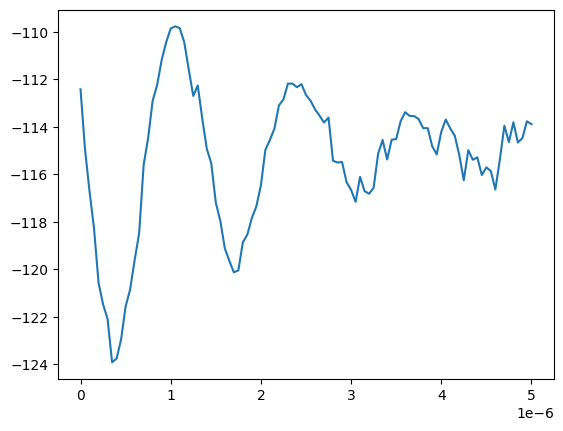

T2_3QTII__2024_08_30__16_30_50


In [1106]:
# Obtém a data e hora atuais
agora = datetime.now()
name = agora.strftime("T2_3QTII__%Y_%m_%d__%H_%M_%S")
howtoplot = "\
    data = np.load('"+name+".npz')\n\
    attenuations = data['Att']\n\
    freqs = data['Freq']\n\
    mags = data['Mag']\n\
    phases = data['Phase']"

alazar_params['recordsPerBuffer'] = 250  # número de capturas por buffer.
alazar_params['buffersPerAcquisition'] = 100 # número de buffers por aquisição.
inst_att.set_attenuation(50)
inst_RFsourceMeasurement.set_frequency(7.021e9-240e6)
inst_RFsourceExcitation.set_frequency(4.2961e9+0.0005e9) # mudar este aqui para o mapa de rabi gustavo: dentro do for 
inst_RFsourceMeasurement.set_amplitude(18)
inst_RFsourceExcitation.set_amplitude(11)
PiPulse = 525e-9

delays = np.arange(0,5e-6,50e-9)

Delay = np.empty(len(delays))
Mag = np.empty(len(delays))  
Phase = np.empty(len(delays)) 


for i, delayy in enumerate(delays):
    Delay[i] = delayy
    Mag[i] = -100
    Phase[i] = 0

inst_awg.stop()
inst_RFsourceMeasurement.stop_rf()
inst_RFsourceExcitation.stop_rf()
sleep(0.5)
# Define-se um pulso Zero
p1 = SquarePulse(length = PiPulse/2,amplitude = 1)
p2 = ZeroPulse(length = RFMeasurementLength)

s1 = PulseSequence('Twotone', 10e-9)
s1.clear()

s1.add(p = p1, channel = 'I', delay = 0)#+PiPulse/2)
s1.add(p = p1, channel = 'I', delay = RFMeasurementLength)
s1.add(p = p2, channel = 'm')

ms.prepareChannelData(sequence = s1, totalExperimentDuration = 500e-6)
sleep(2)
inst_awg.freeMemory()
sleep(0.5)
ms.allocAwgMemory()
sleep(0.5)
ms.loadChannelDataToAwg('I')
sleep(0.5)
ms.loadChannelDataToAwg('m')
sleep(0.5)
ms.setInstrumentsMarker(1)
sleep(0.5)

inst_awg.start()
inst_RFsourceMeasurement.start_rf()
inst_RFsourceExcitation.start_rf()
sleep(1)

#Loop de Medidas
for i, delayy in enumerate(delays):

    s1.clear()
    s1.add(p = p1, channel = 'I', delay = delayy)#+PiPulse/2)
    s1.add(p = p1, channel = 'I', delay = RFMeasurementLength)
    s1.add(p = p2, channel = 'm')
    ms.updateChannelData(sequence = s1, channelName = 'I')
    sleep(0.5)
    ms.loadChannelDataToAwg('I') # Quando usa o canal Q, não precisa atualizar o m, a menos que haja alteração de dados no canal m
    sleep(0.5)
    ms.loadChannelDataToAwg('m')
    sleep(0.5)
    ms.setInstrumentsMarker(1)
    sleep(0.5)

    I,Q = capture()
    sleep(0.5)
    Mag[i] = 20*np.log(np.sqrt(I**2+Q**2))
    Phase[i] = np.arctan2(Q, I)

    # Limpa o gráfico atual
    #plt.gcf().clear()
    clear_output(wait=True)
    #plt.plot(Freq,Mag)

    #fig, ax = plt.subplots(1,2,figsize=(14, 5))
    #ax[1].set_title("Phase")
    #ax[1].plot(Freq,Phase)
    #ax[0].set_title("Mag")
    #ax[0].plot(Freq,Mag)
    plt.plot(Delay,Mag)
    plt.pause(0.05)
    #plt.show()
    np.savez(name,header=howtoplot,Delay=Delay,Mag=Mag,Phase=Phase)
    sleep(0.05)
    
inst_RFsourceMeasurement.stop_rf()
inst_awg.stop()
print(name)

T2_3QTII__2024_08_30__16_30_50.npz


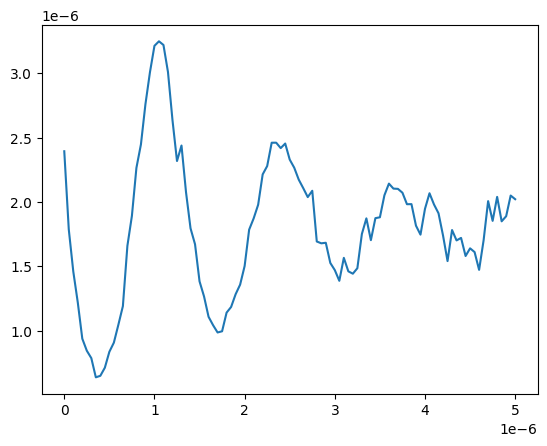

In [1153]:
dados = np.load('T2_3QTII__2024_08_30__16_30_50.npz')
dados["header"]
Delay = dados['Delay']
Mag = dados['Mag']
Mag = 10**(Mag/20)
Phase = dados['Phase']
plt.plot(Delay,Mag)
#plt.vlines(0.525e-6,-110,-130)
print('T2_3QTII__2024_08_30__16_30_50.npz')

In [1111]:
from scipy.optimize import curve_fit

def clear_output(wait=False):
    """Clear the output of the current cell receiving output.

    Parameters
    ----------
    wait : bool [default: false]
        Wait to clear the output until new output is available to replace it."""
    from IPython.core.interactiveshell import InteractiveShell
    if InteractiveShell.initialized():
        InteractiveShell.instance().display_pub.clear_output(wait)
    else:
        print('\033[2K\r', end='')
        sys.stdout.flush()
        print('\033[2K\r', end='')
        sys.stderr.flush()

def arredonda(numero):
    if numero == 0:
        return 0, 0
    
    # Encontra o expoente do primeiro algarismo significativo
    expoente = -int(math.floor(math.log10(abs(numero))))
    
    # Arredonda o número para o primeiro algarismo significativo
    numero_arredondado = round(numero, expoente)
    
    # Converte o número arredondado para string
    numero_str = str(numero_arredondado)
    
    # Encontra a posição da vírgula
    pos_virgula = numero_str.find('.')
    
    # Determina o número de casas decimais após a vírgula
    casas_decimais = len(numero_str) - pos_virgula - 1 if pos_virgula != -1 else 0
    
    # Corrige o número de casas decimais se o número arredondado for inteiro
    if pos_virgula == -1:
        casas_decimais = 0
    
    return numero_arredondado, max(casas_decimais, 0)


def Ramsey_g(time, Const, Slope,Tr,freq,Phase):
#     Const,Const1, Slope,Tr,freq,Phase = args
    """
    T2 curve using gaussian decay: (Const + Slope*exp(-0.5*((time-Const1)/Tr)**2)*cos( (2*pi*time/freq) + Phase))
    """
    
    return  (Const + Slope*np.exp(-0.5*(time/Tr)**2)*np.cos( (2*np.pi*time/freq) + Phase))

def Ramsey_e(time, Const, Slope,Tr,freq,Phase):
    
#     Const, Const1, Slope, Tr, freq, Phase = args
    """
    T2 curve using exponential decay: (Const + Slope*exp(-0.5*((time-Const1)/Tr)**2)*cos( (2*pi*time/freq) + Phase))
    """
    return (Const + Slope*np.exp(-time/Tr)*np.cos( (2*np.pi*time/freq) + Phase))



def Plot_Ramsey(time,data, argsinic):
    args = argsinic
    popt, pcov = curve_fit(Ramsey_e, time, data, p0=args,maxfev=10000,ftol=1e-15 )   
    T2 = round(popt[2]*1e6,1)
    perr = np.sqrt(np.diag(pcov))
    desvT2 = round(perr[2]*1e6,1)
    
    plt.plot(time*1e6,data,'-o',linewidth=2,markersize=8)
    plt.plot(time*1e6,Ramsey_e(time,*popt) ,c='r', label = f"$T_2^*$ = {T2}$\pm${desvT2} $\mu$s")
    plt.xlabel("Delay Time ($\mu$s)", fontsize=22)
    plt.xticks(fontsize = 15)
    plt.ylabel("Mag", fontsize=22)
    plt.yticks(fontsize = 15)
    plt.legend(prop={"size":18})
    plt.title("Ramsey Measurement", fontsize=22)
    
    return T2, desvT2

(2.3, 0.1)

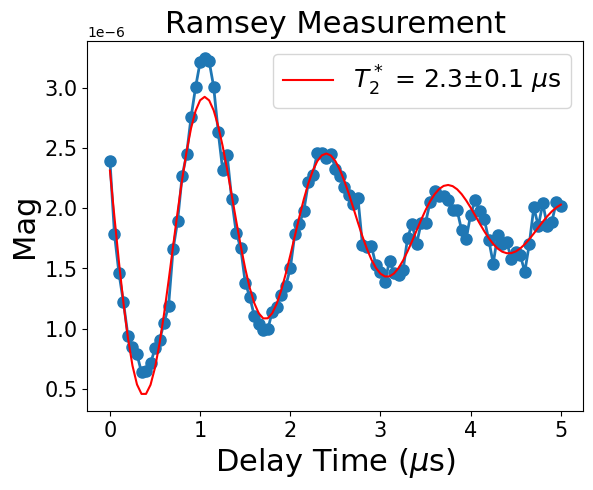

In [1156]:
chute = [2, 1,135e-9,2e-6,0]
Plot_Ramsey(Delay,Mag, chute)

### Echo

In [48]:
inst_awg.stop()

# Define-se um pulso Zero
p1 = SquarePulse(length = 25e-9)
p2 = SquarePulse(length = 50e-9)
p3 = ZeroPulse(length = RFMeasurementLength)

s1 = PulseSequence('Twotone', 1e-6)

s1.clear()

s1.add(p = p1, channel = 'Q')
s1.add(p = p2, channel = 'Q')
s1.add(p = p1, channel = 'Q', delay = RFMeasurementLength)
s1.add(p = p3, channel = 'm')


In [49]:
ms.prepareChannelData(sequence = s1, totalExperimentDuration = 200e-6)

inst_awg.freeMemory()

ms.allocAwgMemory()
sleep(0.05)
ms.loadChannelDataToAwg('Q')
sleep(0.05)
ms.loadChannelDataToAwg('m')
sleep(0.05)

# Atualiza o marker da fonte de excitação
ms.setInstrumentsMarker(1)

In [50]:
inst_awg.start()

In [51]:
delays = np.arange(0,1000e-9,10e-9)

for delay in delays:

    s1.clear()

    s1.add(p = p1, channel = 'Q', delay = delay)
    s1.add(p = p2, channel = 'Q', delay = delay)
    s1.add(p = p1, channel = 'Q', delay = RFMeasurementLength)
    s1.add(p = p3, channel = 'm')

    ms.updateChannelData(sequence = s1, channelName = 'Q')

    ms.loadChannelDataToAwg('Q')  # Quando usa o canal Q, não precisa atualizar o m, a menos que haja alteração de dados no canal m

    ms.setInstrumentsMarker(1)

    sleep(0.5)


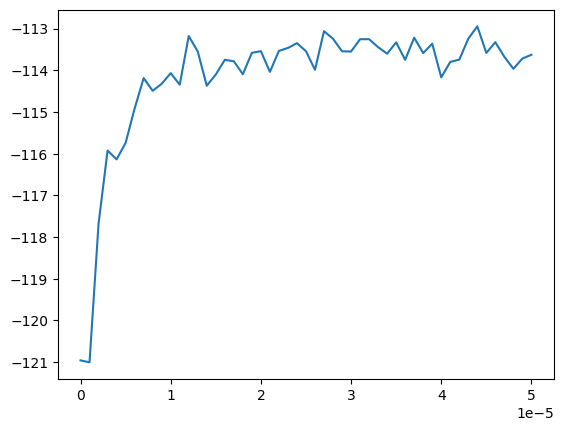

T1_3QTII__2024_08_30__18_03_44


In [1120]:
# Obtém a data e hora atuais
agora = datetime.now()
name = agora.strftime("T2e_3QTII__%Y_%m_%d__%H_%M_%S")
howtoplot = "\
    data = np.load('"+name+".npz')\n\
    attenuations = data['Att']\n\
    freqs = data['Freq']\n\
    mags = data['Mag']\n\
    phases = data['Phase']"

alazar_params['recordsPerBuffer'] = 250  # número de capturas por buffer.
alazar_params['buffersPerAcquisition'] = 100 # número de buffers por aquisição.
inst_att.set_attenuation(50)
inst_RFsourceMeasurement.set_frequency(7.021e9-240e6)
inst_RFsourceExcitation.set_frequency(4.2961e9) # mudar este aqui para o mapa de rabi gustavo: dentro do for 
inst_RFsourceMeasurement.set_amplitude(18)
inst_RFsourceExcitation.set_amplitude(11)
PiPulse = 525e-9

delays = np.arange(0,50e-6,1000e-9)

Delay = np.empty(len(delays))
Mag = np.empty(len(delays))  
Phase = np.empty(len(delays)) 


for i, delayy in enumerate(delays):
    Delay[i] = delayy
    Mag[i] = -100
    Phase[i] = 0

inst_awg.stop()
inst_RFsourceMeasurement.stop_rf()
inst_RFsourceExcitation.stop_rf()
sleep(0.5)
# Define-se um pulso Zero
p1 = SquarePulse(length = PiPulse/2,amplitude = 1)
p2 = SquarePulse(length = PiPulse,amplitude = 1)
p3 = ZeroPulse(length = RFMeasurementLength)

s1 = PulseSequence('Twotone', 10e-9)
s1.clear()
s1.add(p = p1, channel = 'I', delay = delayy)
s1.add(p = p2, channel = 'I', delay = delayy)
s1.add(p = p1, channel = 'I', delay = RFMeasurementLength)
s1.add(p = p3, channel = 'm')

ms.prepareChannelData(sequence = s1, totalExperimentDuration = 500e-6)
sleep(2)
inst_awg.freeMemory()
sleep(0.5)
ms.allocAwgMemory()
sleep(0.5)
ms.loadChannelDataToAwg('I')
sleep(0.5)
ms.loadChannelDataToAwg('m')
sleep(0.5)
ms.setInstrumentsMarker(1)
sleep(0.5)

inst_awg.start()
inst_RFsourceMeasurement.start_rf()
inst_RFsourceExcitation.start_rf()
sleep(1)

#Loop de Medidas
for i, delayy in enumerate(delays):

    s1.clear()
    s1.add(p = p1, channel = 'I', delay = delayy)
    s1.add(p = p2, channel = 'I', delay = delayy)
    s1.add(p = p1, channel = 'I', delay = RFMeasurementLength)
    s1.add(p = p3, channel = 'm')
    
    ms.updateChannelData(sequence = s1, channelName = 'I')
    sleep(0.5)
    ms.loadChannelDataToAwg('I') # Quando usa o canal Q, não precisa atualizar o m, a menos que haja alteração de dados no canal m
    sleep(0.5)
    ms.loadChannelDataToAwg('m')
    sleep(0.5)
    ms.setInstrumentsMarker(1)
    sleep(0.5)

    I,Q = capture()
    sleep(0.5)
    Mag[i] = 20*np.log(np.sqrt(I**2+Q**2))
    Phase[i] = np.arctan2(Q, I)

    # Limpa o gráfico atual
    #plt.gcf().clear()
    clear_output(wait=True)
    #plt.plot(Freq,Mag)

    #fig, ax = plt.subplots(1,2,figsize=(14, 5))
    #ax[1].set_title("Phase")
    #ax[1].plot(Freq,Phase)
    #ax[0].set_title("Mag")
    #ax[0].plot(Freq,Mag)
    plt.plot(Delay,Mag)
    plt.pause(0.05)
    #plt.show()
    np.savez(name,header=howtoplot,Delay=Delay,Mag=Mag,Phase=Phase)
    sleep(0.05)
    
inst_RFsourceMeasurement.stop_rf()
inst_awg.stop()
print(name)

T1_3QTII__2024_08_30__18_03_44.npz


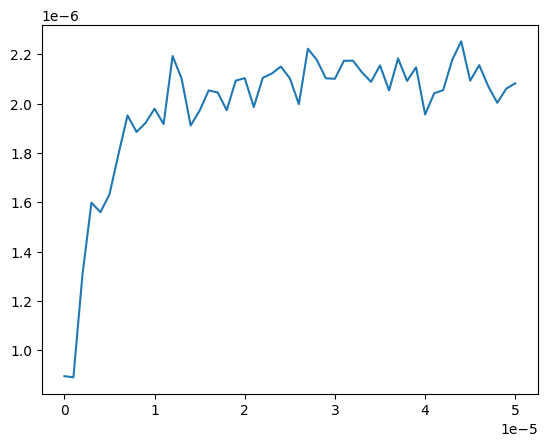

In [1149]:
dados = np.load('T1_3QTII__2024_08_30__18_03_44.npz')
dados["header"]
Delay = dados['Delay']
Mag = dados['Mag']
Mag = 10**(Mag/20)
Phase = dados['Phase']
plt.plot(Delay,Mag)
#plt.vlines(0.525e-6,-110,-130)
print('T1_3QTII__2024_08_30__18_03_44.npz')

In [1150]:
# T1 exponential

from scipy.optimize import curve_fit
args_T1 = [2.2,-0.002,4e-6] # initial parameter to fit
#"""
#[Const, Slope,T1]{Const + Slope*exp(-time/T1)}
#"""
popt,pcov = curve_fit(T1, Delay, Mag, p0=args_T1)   
#print(r'T1 (Exponential): {0:.2f} +- {1:.2f} µs'.format(popt[2]*1e6,pcov[2]*1e6))

In [1151]:
T2 = round(popt[2]*1e6,1)
perr = np.sqrt(np.diag(pcov))
desvT2 = round(perr[2]*1e6,1)

print( T2, desvT2 )

4.3 0.4


Text(0.5, 1.0, '$T_2^{echo}$ Measurement')

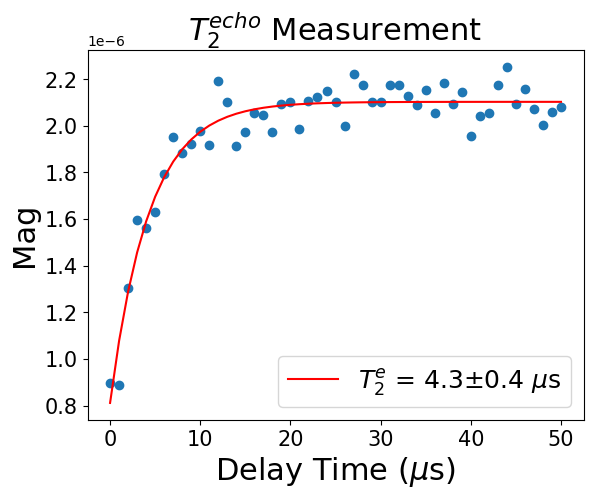

In [1152]:
plt.scatter(Delay*1e6,Mag)
plt.plot(Delay*1e6,T1(Delay,*popt), label = f"$T_2^e$ = {T2}$\pm${desvT2} $\mu$s", color = "red")
plt.legend(prop={"size":18})
plt.xlabel("Delay Time ($\mu$s)", fontsize=22)
plt.xticks(fontsize = 15)
plt.ylabel("Mag", fontsize=22)
plt.yticks(fontsize = 15)
#plt.legend()
plt.title("$T_2^{echo}$ Measurement", fontsize=22)

### Uma sequência de Pulsos Arbitrária

In [46]:
inst_awg.stop()

# Define-se um pulso Zero
p1 = SquarePulse(length = 25e-9)
p2 = SquarePulse(length = 50e-9)
p3 = GaussianPulse(length = 50e-9, amplitude = 1, sigma = 10e-9)
p5 = ZeroPulse(length = RFMeasurementLength)


p4 = DPC.build()

s1 = PulseSequence('Twotone', 1e-6)

s1.clear()

s1.add(p = p1, channel = 'Q', delay = 100e-9)
s1.add(p = p1, channel = 'Q', delay = RFMeasurementLength)

s1.add(p = p3, channel = 'I', delay = 50e-9)
s1.add(p = p2, channel = 'I', delay = RFMeasurementLength)

s1.add(p = p5, channel = 'm')


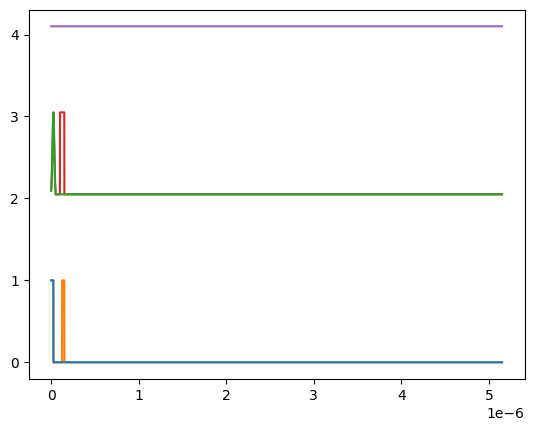

In [48]:
s1.show_all()

In [49]:
ms.prepareChannelData(sequence = s1, totalExperimentDuration = 200e-6)

inst_awg.freeMemory()

ms.allocAwgMemory()
sleep(0.05)
ms.loadChannelDataToAwg('Q')
sleep(0.05)
ms.loadChannelDataToAwg('I')
sleep(0.05)
ms.loadChannelDataToAwg('m')
sleep(0.05)

# Atualiza o marker da fonte de excitação
ms.setInstrumentsMarker(1)

In [50]:
inst_awg.start()

### Drag Pulse 

In [13]:
inst_awg.stop()

# Define-se um pulso Zero
p5 = ZeroPulse(length = RFMeasurementLength)

DPC = DragPulseConstructor(length = 100e-9, alpha = 1, beta = 1, sigma = 2e-9)

p4 = DPC.build()

s1 = PulseSequence('Twotone', 1e-6)

s1.clear()

s1.add(p = p4.Q, channel = 'Q', delay = RFMeasurementLength+100e-9)


s1.add(p = p4.I, channel = 'I', delay = RFMeasurementLength+100e-9)

s1.add(p = p5, channel = 'm')


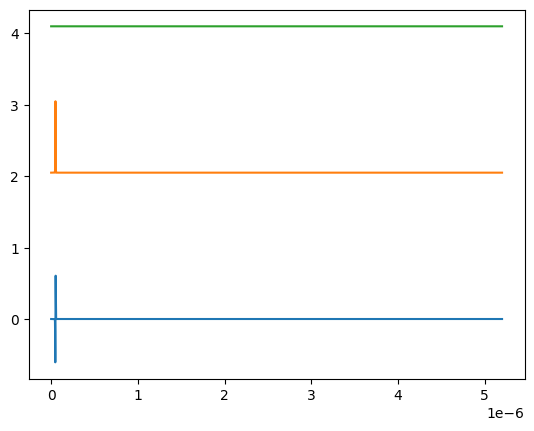

In [14]:
s1.show_all()

In [ ]:
ms.prepareChannelData(sequence = s1, totalExperimentDuration = 200e-6)

inst_awg.freeMemory()

ms.allocAwgMemory()
sleep(0.05)
ms.loadChannelDataToAwg('Q')
sleep(0.05)
ms.loadChannelDataToAwg('I')
sleep(0.05)
ms.loadChannelDataToAwg('m')
sleep(0.05)

# Atualiza o marker da fonte de excitação
ms.setInstrumentsMarker(1)